In [12]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from sklearn import model_selection
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

In [13]:
def padronizar_normal(matriz_X):
    for i in range(np.shape(matriz_X)[1]):
        matriz_X[:,i] = (matriz_X[:,i] - np.mean(matriz_X[:,i]))/np.std(matriz_X[:,i]) # X menos media/desvio padrao

    return matriz_X

def normalizar(X):
    min_values = X.min(axis=0)
    max_values = X.max(axis=0)
    X = (X - min_values) / (max_values - min_values)
    return X

In [14]:
def k_fold(num_splits, numero_neuronios, num_camadas,dimensao_imput, list_funcoes_ativacao, X_train, Y_train, RANDOM_STATE, BATCH_SIZE, es = False, regularizador = False):
  kfold = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=RANDOM_STATE)
  accuracies_train = []
  accuracies_val = []
  history_list = []
  tamanho_history_history_loss_list = []
  i = 0
  for index_treino, index_val in kfold.split(X_train, Y_train):
      i += 1
      X_train_fold, X_val_fold = X_train[index_treino], X_train[index_val]
      Y_train_fold, Y_val_fold = Y_train[index_treino], Y_train[index_val]

      # Criando a rede neural
      model = Sequential()
      # Adicionando neurônios em uma camada oculta
      for _ in range(num_camadas):
        if regularizador == False:
          model.add(Dense(numero_neuronios, input_dim=dimensao_imput, kernel_initializer='normal', activation=list_funcoes_ativacao[0])) #quantidade de neuronios na camada escondida, nº de features (selu, relu, gelu)
        else:
          model.add(Dense(numero_neuronios, input_dim=dimensao_imput, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01),activation=list_funcoes_ativacao[0]))
      model.add(Dense(1, kernel_initializer='normal', activation=list_funcoes_ativacao[1])) #camada de saída

      # adicionando a taxa de aprendizado
      learning_rate = 0.001  

      # Criando um otimizador Adam com a taxa de aprendizado desejada
      otimizador = optimizers.Adam(learning_rate=learning_rate)

      if es == False:
        # Compilando o modelo
        model.compile(loss = 'binary_crossentropy', optimizer = otimizador, metrics = ['accuracy'])
        #Treinando o modelo
        history = model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=250, batch_size=BATCH_SIZE, verbose=0)
        history_list.append(history)
        tamanho_history_history_loss_list.append(len(history.history['loss']))

      else:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
        # Compilando o modelo
        model.compile(loss = 'binary_crossentropy', optimizer = otimizador, metrics = ['accuracy'])
        #Treinando o modelo
        history = model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=250, batch_size=BATCH_SIZE, verbose=0, callbacks = [es])
        history_list.append(history)
        tamanho_history_history_loss_list.append(len(history.history['loss']))


      # Avalia o modelo
      _, accuracy_train = model.evaluate(X_train_fold, Y_train_fold, batch_size=BATCH_SIZE, verbose=0)
      _, accuracy_val = model.evaluate(X_val_fold, Y_val_fold, batch_size=BATCH_SIZE, verbose=0)
      accuracies_train.append(accuracy_train)
      accuracies_val.append(accuracy_val)

      # Exibe o historico de treinamento para um fold especifico
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title(f'Metrica de erro - Fold {i}')
      plt.ylabel('Erro')
      plt.xlabel('Epoca')
      plt.legend(['Treinamento', 'Validacao'])
      plt.show()

      print(f'--> Acuracia (treino): {accuracy_train:.4f}')
      print(f'--> Acuracia (validacao): {accuracy_val:.4f}')
      print(f"--> Ein - Eval = {accuracy_train - accuracy_val:.4f}") 
      print(f"--> val_loss - train_loss = {(history.history['val_loss'][-1] - history.history['loss'][-1]):.4f}\n")
        

  # Calcula a acuracia media
  acuracia_media_treino = np.mean(accuracies_train)
  acuracia_media_validacao = np.mean(accuracies_val)

  # Historico com valores medios dos folds
  history_train_loss_avg_list = []
  history_val_losso_avg_list = []

  for epoca in range(max(tamanho_history_history_loss_list)):
      list_valores_loss_train = []
      list_valores_loss_val = []
      for j in range(len(history_list)):
          if epoca < len(history_list[j].history['loss']): # verifica se a epoca existe no historico do fold j por causa do early stopping
              list_valores_loss_train.append(history_list[j].history['loss'][epoca])
              list_valores_loss_val.append(history_list[j].history['val_loss'][epoca])
      history_train_loss_avg_list.append(np.mean(list_valores_loss_train)) # Calcula a média dos valores de loss para cada epoca (media da epoca 1, media da epoca 2...)
      history_val_losso_avg_list.append(np.mean(list_valores_loss_val))                           

  loss_medio_treino = np.mean(history_train_loss_avg_list)
  loss_medio_val = np.mean(history_val_losso_avg_list)

  plt.plot(history_train_loss_avg_list)
  plt.plot(history_val_losso_avg_list)
  plt.title('Metrica de erro - Media dos Folds')
  plt.ylabel('Erro')
  plt.xlabel('Epoca')
  plt.legend(['Treinamento', 'Validacao'])
  plt.show()

  print(f'--> Acuracia media (treino): {acuracia_media_treino:.4f}')
  print(f'--> Acuracia media (validacao): {acuracia_media_validacao:.4f}')
  print(f"--> acc_in - acc_val = {acuracia_media_treino - acuracia_media_validacao:.4f}")
  print(f"--> loss medio do treino = {loss_medio_treino:.4f}")
  print(f"--> loss medio da validacao = {loss_medio_val:.4f}")  
  print(f"--> val_loss - train_loss = {(loss_medio_val - loss_medio_treino):.4f}\n")

# Leitura da instância e atribuição do X e do Y

In [15]:
data = pd.read_csv('instancias modelos/dataset_2T23_22.csv', index_col=0)
data

,1T_Dívida Líquida,1T_EBIT,1T_Lucro Líquido,1T_ROE,1T_Receita Líquida,2T_Dívida Líquida,2T_EBIT,2T_Lucro Líquido,2T_ROE,2T_Receita Líquida,Classificação
Empresa,,,,,,,,,,,
PETR4 - 2022,1.898480e+11,6.539800e+10,4.478300e+10,10.26,1.416410e+11,1.803670e+11,9.643400e+10,5.448400e+10,13.23,1.709600e+11,1
OIBR3 - 2022,2.854196e+10,-3.693700e+08,1.783950e+09,172.14,2.486940e+09,1.616768e+10,-6.114000e+08,-3.206600e+08,-41.52,2.579520e+09,1
B3SA3 - 2022,-5.093250e+09,1.430770e+09,1.101040e+09,5.05,2.284700e+09,-2.477130e+09,1.399600e+09,1.092280e+09,5.29,2.241630e+09,1
ITSA4 - 2022,4.888000e+09,4.167000e+09,3.859000e+09,5.67,2.131000e+09,5.137000e+09,3.270000e+09,3.181000e+09,4.56,2.214000e+09,1
ABEV3 - 2022,-1.124731e+10,4.162330e+09,3.528840e+09,4.32,1.843915e+10,-1.246893e+10,4.034080e+09,3.064050e+09,3.44,1.798900e+10,1
...,...,...,...,...,...,...,...,...,...,...,...
BAHI3 - 2023,1.771930e+08,-7.610000e+06,-1.787200e+07,-30.31,8.677900e+07,1.673060e+08,1.138000e+06,-1.412700e+07,-22.00,1.009340e+08,0
NEXP3 - 2023,4.833700e+07,-1.329800e+07,-1.784300e+07,-18.42,3.006600e+07,5.018700e+07,2.646400e+07,2.987100e+07,-23.20,3.742000e+07,0
EMAE4 - 2023,-4.473750e+08,1.038000e+06,1.888200e+07,1.65,1.375520e+08,-4.688340e+08,1.028100e+07,3.784800e+07,3.39,1.387540e+08,0


In [16]:
print(data['Classificação'].value_counts())
#Retire 45 linhas de classificacao = 0
data = data.drop(data[data.Classificação == 0].sample(45).index)
data['Classificação'].value_counts()

Classificação
0    208
1    163
Name: count, dtype: int64


Classificação
1    163
0    163
Name: count, dtype: int64

In [17]:
X = np.array(data.drop(['Classificação'], axis = 1))
Y = np.array(data['Classificação'])
RANDOM_STATE = 3
BATCH_SIZE = 32
# Padronização
X = padronizar_normal(X)

### Separando em dados de treino e teste

In [18]:
# Separando os dados de treino e teste
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, random_state=RANDOM_STATE,test_size=0.2)
# Separando os dados de treino em treino e validação
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X_train, Y_train, random_state=RANDOM_STATE,test_size=0.2)

print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)
print('X_val:', X_val.shape)
print('Y_val:', Y_val.shape)

X_train: (208, 10)
Y_train: (208,)
X_val: (52, 10)
Y_val: (52,)


In [19]:
# Encontrando o numero de neuronios na camada escondida usando a dimensão vc
num_neuronios = (X_train.shape[0] - 10)/(10*(X_train.shape[1] + 2))
num_neuronios

1.65

# Utilizando o K-fold para checar se existe overfitting e o modelo

c:\Users\Bergson\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


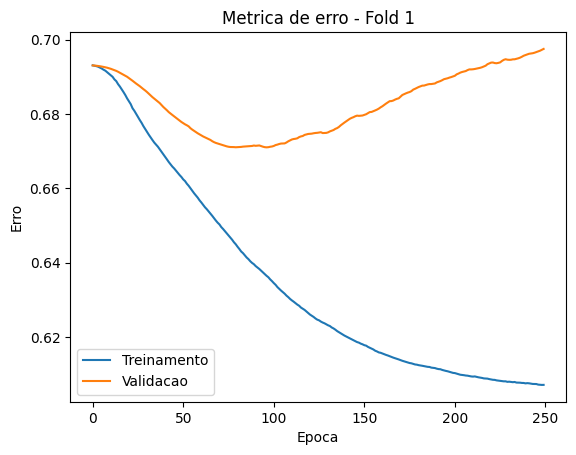

--> Acuracia (treino): 0.6084
--> Acuracia (validacao): 0.6429
--> Ein - Eval = -0.0344
--> val_loss - train_loss = 0.0904



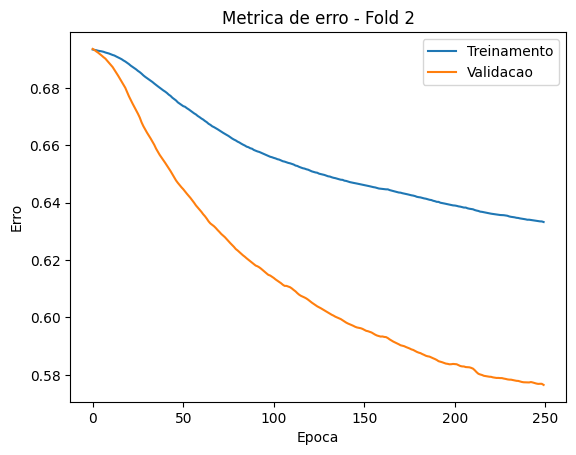

--> Acuracia (treino): 0.6084
--> Acuracia (validacao): 0.6190
--> Ein - Eval = -0.0106
--> val_loss - train_loss = -0.0568



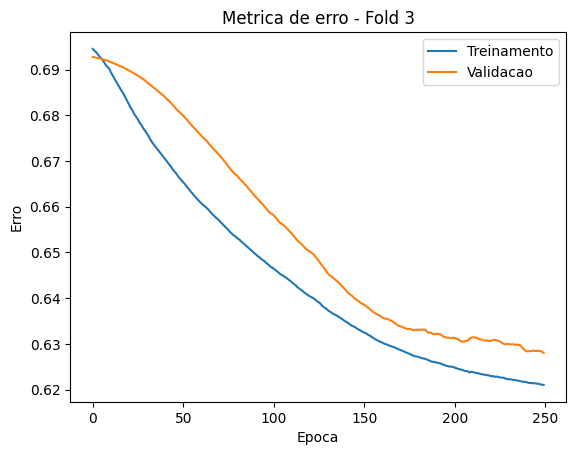

--> Acuracia (treino): 0.6205
--> Acuracia (validacao): 0.5952
--> Ein - Eval = 0.0252
--> val_loss - train_loss = 0.0070



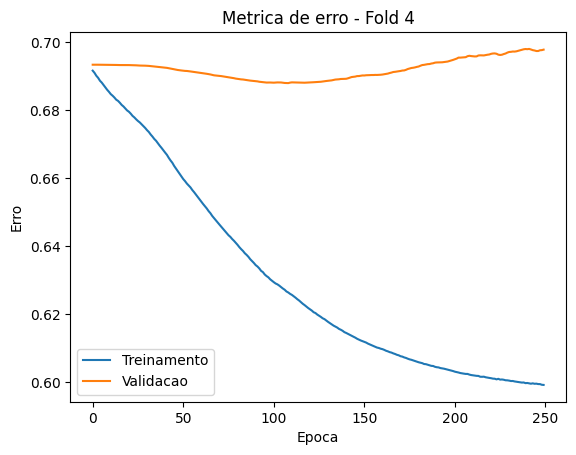

--> Acuracia (treino): 0.6527
--> Acuracia (validacao): 0.4878
--> Ein - Eval = 0.1649
--> val_loss - train_loss = 0.0985



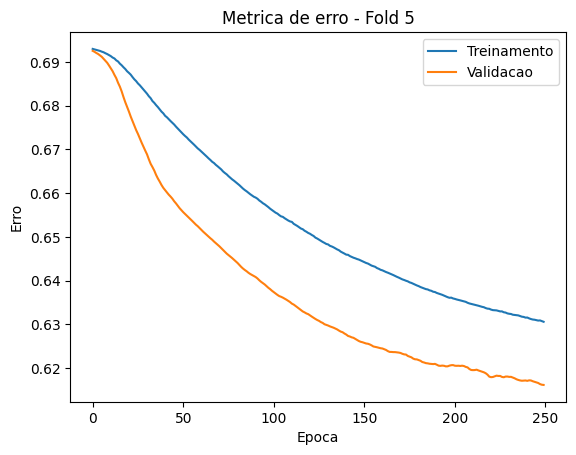

--> Acuracia (treino): 0.6347
--> Acuracia (validacao): 0.6341
--> Ein - Eval = 0.0006
--> val_loss - train_loss = -0.0144



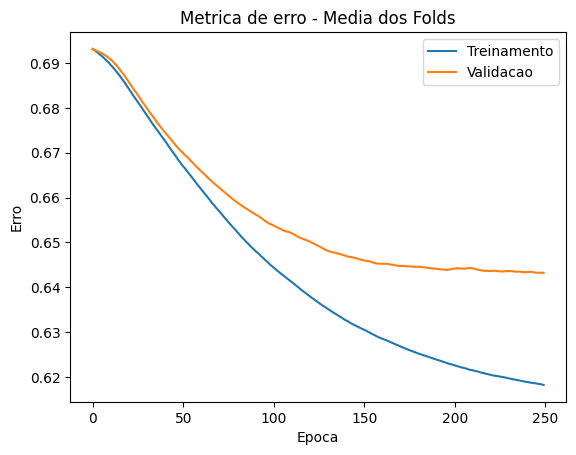

--> Acuracia media (treino): 0.6250
--> Acuracia media (validacao): 0.5958
--> acc_in - acc_val = 0.0291
--> loss medio do treino = 0.6440
--> loss medio da validacao = 0.6564
--> val_loss - train_loss = 0.0124



In [20]:
# Parâmetros: num_splits, numero_neuronios, numero_camadas, dimensao_imput, list_funcoes_ativacao, X_train, Y_train, RANDOM_STATE, BATCH_SIZE, es = False, regularizador = False
k_fold(5, 2, 1, X_train.shape[1], ['gelu', 'sigmoid'], X_train, Y_train, RANDOM_STATE, BATCH_SIZE)

- Nota-se que ocorreu overfitting e que a acurácia está baixa, além de uma perda alta. Isso significa que o modelo não está conseguindo aprender com o passar das épocas.

# Forçando o overfitting

c:\Users\Bergson\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


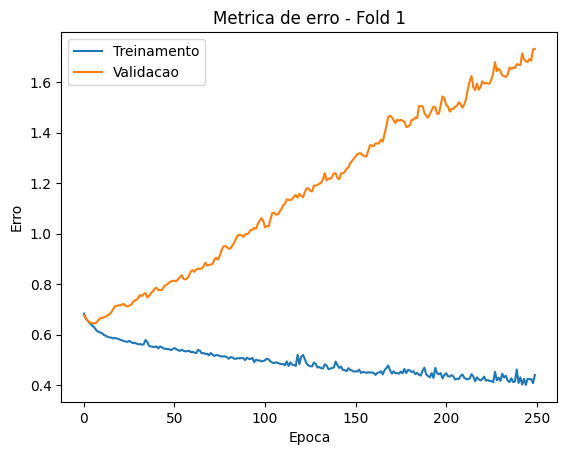

--> Acuracia (treino): 0.8193
--> Acuracia (validacao): 0.5714
--> Ein - Eval = 0.2478
--> val_loss - train_loss = 1.2915



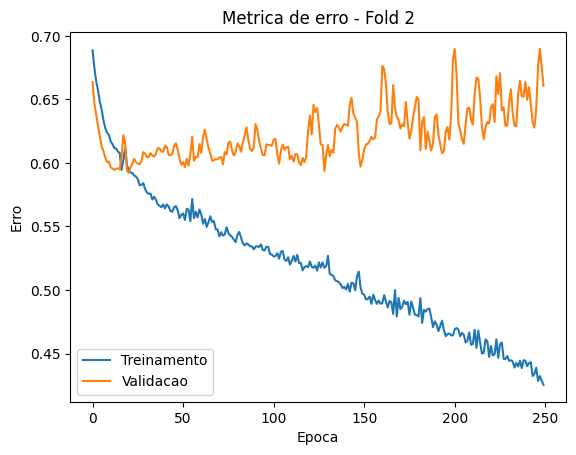

--> Acuracia (treino): 0.8072
--> Acuracia (validacao): 0.5714
--> Ein - Eval = 0.2358
--> val_loss - train_loss = 0.2354



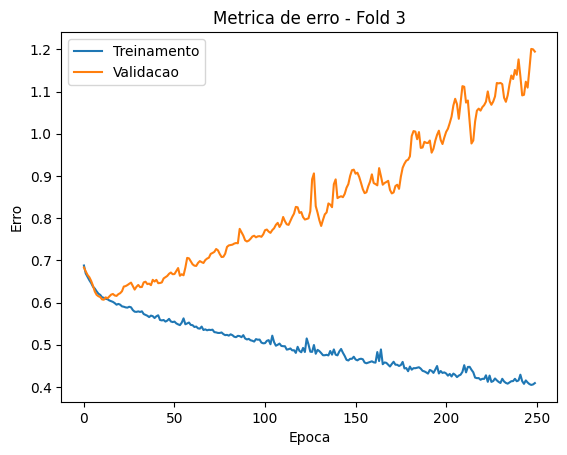

--> Acuracia (treino): 0.7892
--> Acuracia (validacao): 0.5238
--> Ein - Eval = 0.2653
--> val_loss - train_loss = 0.7858



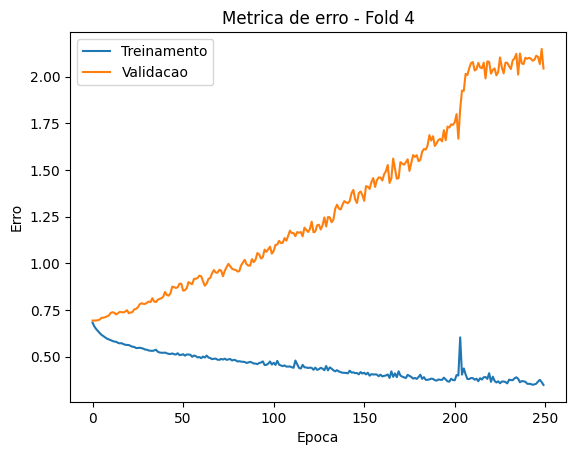

--> Acuracia (treino): 0.8323
--> Acuracia (validacao): 0.4390
--> Ein - Eval = 0.3933
--> val_loss - train_loss = 1.6951



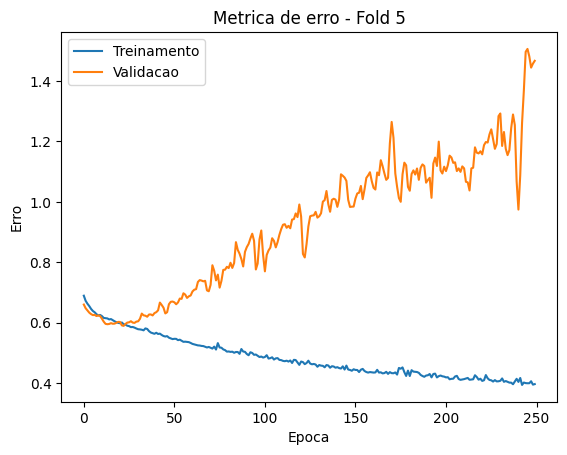

--> Acuracia (treino): 0.7784
--> Acuracia (validacao): 0.6098
--> Ein - Eval = 0.1687
--> val_loss - train_loss = 1.0714



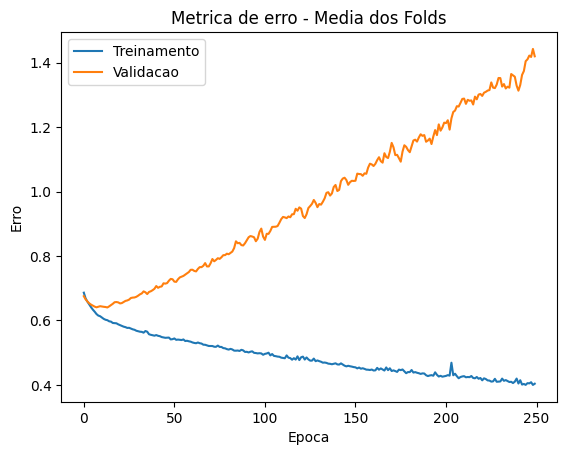

--> Acuracia media (treino): 0.8053
--> Acuracia media (validacao): 0.5431
--> acc_in - acc_val = 0.2622
--> loss medio do treino = 0.4877
--> loss medio da validacao = 0.9732
--> val_loss - train_loss = 0.4855



In [22]:
# Parâmetros: num_splits, numero_neuronios, numero_camadas, dimensao_imput, list_funcoes_ativacao, X_train, Y_train, RANDOM_STATE, BATCH_SIZE, es = False, regularizador = False
k_fold(5, 200, 2, X_train.shape[1], ['relu', 'sigmoid'], X_train, Y_train, RANDOM_STATE, BATCH_SIZE)

- Ocorreu um aumento da acurácia do treino para 84%, consideravelmente melhor que o anterior. Entretanto, o overfitting está bastante elevado.

# Tratando o overfitting do primeiro K-fold, com 2 neurônios e uma camada oculta

c:\Users\Bergson\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 122: early stopping


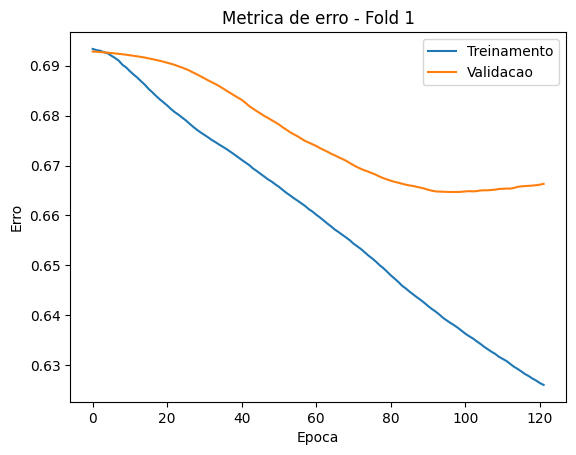

--> Acuracia (treino): 0.5904
--> Acuracia (validacao): 0.7381
--> Ein - Eval = -0.1477
--> val_loss - train_loss = 0.0403



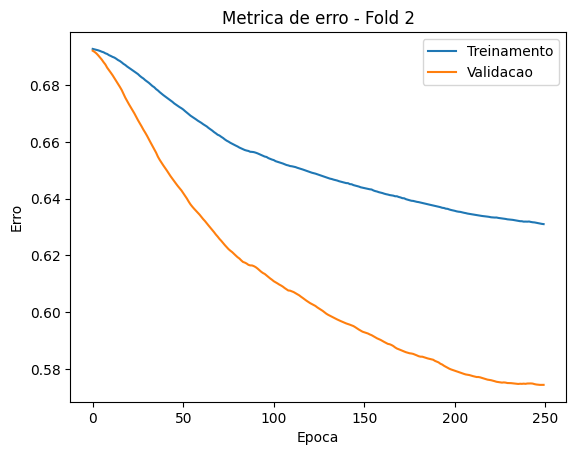

--> Acuracia (treino): 0.6084
--> Acuracia (validacao): 0.6667
--> Ein - Eval = -0.0582
--> val_loss - train_loss = -0.0567



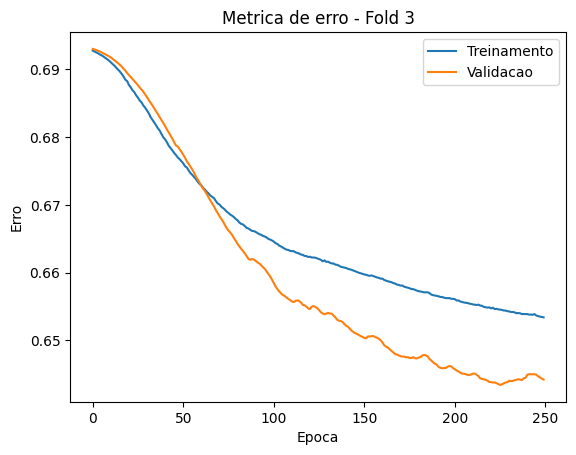

--> Acuracia (treino): 0.6205
--> Acuracia (validacao): 0.6429
--> Ein - Eval = -0.0224
--> val_loss - train_loss = -0.0092

Epoch 143: early stopping


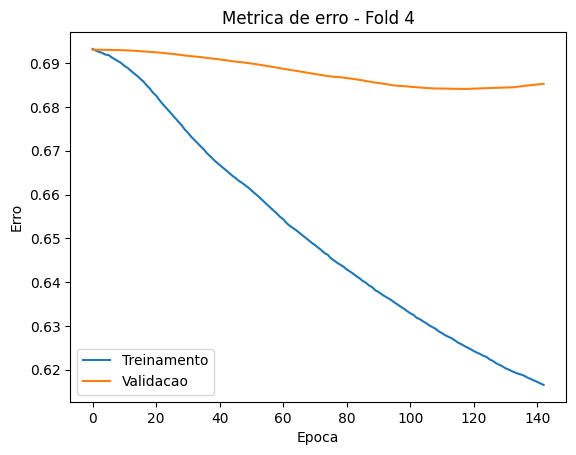

--> Acuracia (treino): 0.6467
--> Acuracia (validacao): 0.4878
--> Ein - Eval = 0.1589
--> val_loss - train_loss = 0.0688

Epoch 200: early stopping


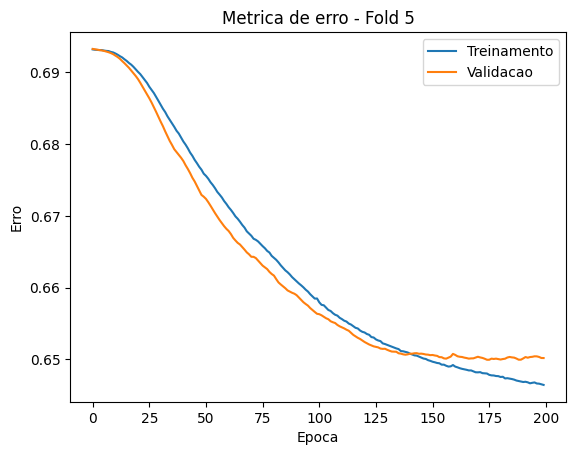

--> Acuracia (treino): 0.6108
--> Acuracia (validacao): 0.6341
--> Ein - Eval = -0.0234
--> val_loss - train_loss = 0.0037



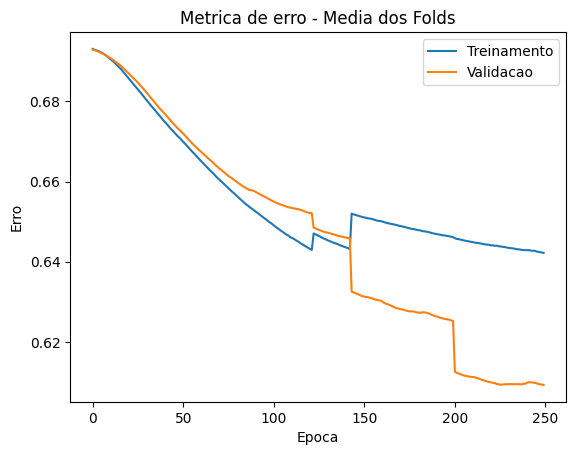

--> Acuracia media (treino): 0.6154
--> Acuracia media (validacao): 0.6339
--> acc_in - acc_val = -0.0186
--> loss medio do treino = 0.6561
--> loss medio da validacao = 0.6465
--> val_loss - train_loss = -0.0096



In [25]:
# Parâmetros: num_splits, numero_neuronios,dimensao_imput, list_funcoes_ativacao, X_train, Y_train, RANDOM_STATE, BATCH_SIZE, es = False, regularizador = False
k_fold(5, 2, 1, X_train.shape[1], ['gelu', 'sigmoid'], X_train, Y_train, RANDOM_STATE, BATCH_SIZE, es = True)

# Tratando o overfitting da rede com 200 neurônios

c:\Users\Bergson\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 99: early stopping


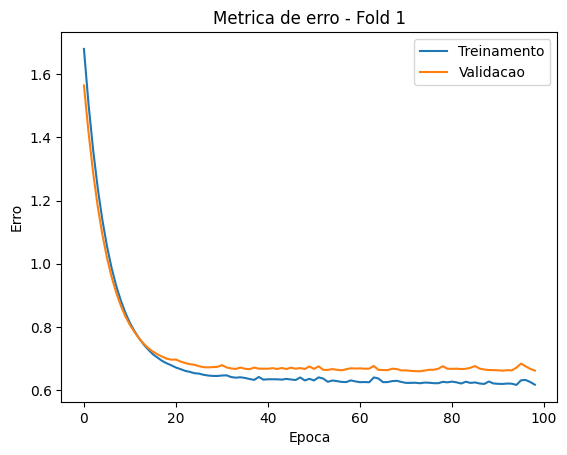

--> Acuracia (treino): 0.6265
--> Acuracia (validacao): 0.7143
--> Ein - Eval = -0.0878
--> val_loss - train_loss = 0.0445

Epoch 72: early stopping


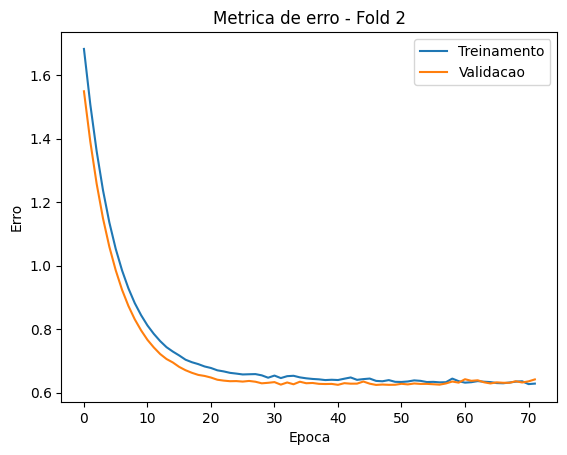

--> Acuracia (treino): 0.6687
--> Acuracia (validacao): 0.6429
--> Ein - Eval = 0.0258
--> val_loss - train_loss = 0.0132

Epoch 67: early stopping


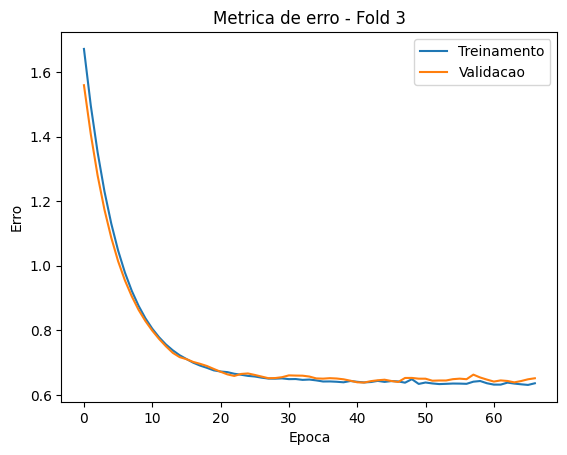

--> Acuracia (treino): 0.6506
--> Acuracia (validacao): 0.7619
--> Ein - Eval = -0.1113
--> val_loss - train_loss = 0.0155

Epoch 62: early stopping


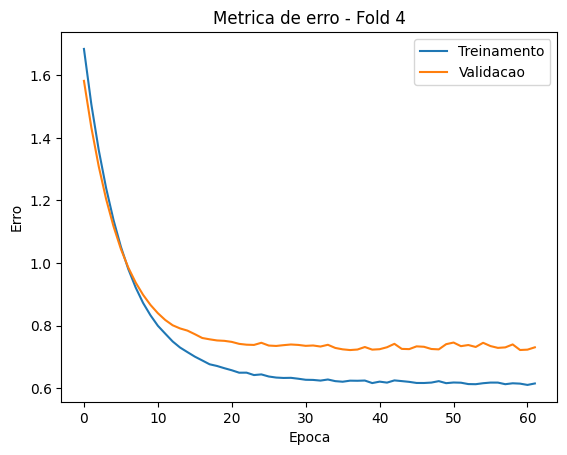

--> Acuracia (treino): 0.6707
--> Acuracia (validacao): 0.5854
--> Ein - Eval = 0.0853
--> val_loss - train_loss = 0.1155

Epoch 135: early stopping


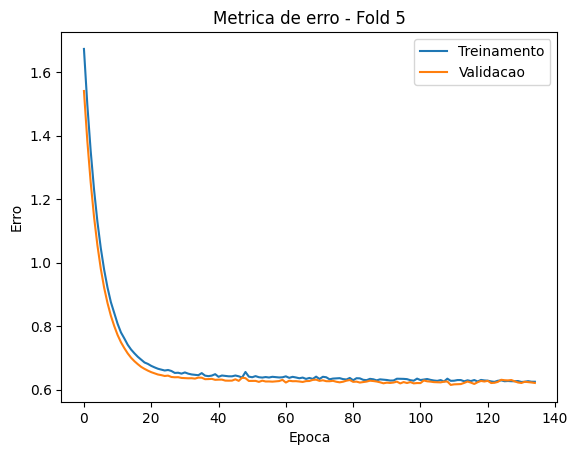

--> Acuracia (treino): 0.6527
--> Acuracia (validacao): 0.6341
--> Ein - Eval = 0.0185
--> val_loss - train_loss = -0.0038



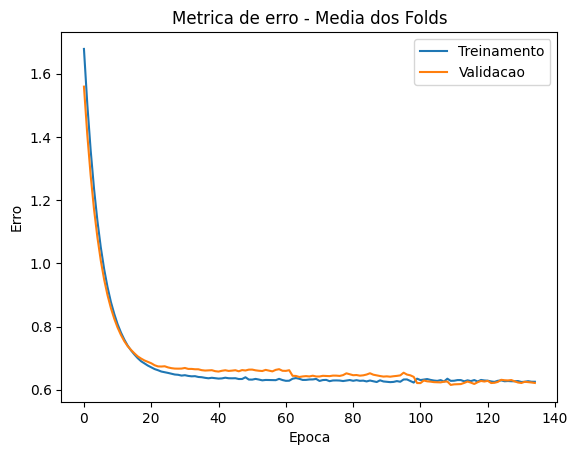

--> Acuracia media (treino): 0.6538
--> Acuracia media (validacao): 0.6677
--> acc_in - acc_val = -0.0139
--> loss medio do treino = 0.6790
--> loss medio da validacao = 0.6856
--> val_loss - train_loss = 0.0066



In [27]:
# Parâmetros: num_splits, numero_neuronios, numero_camadas, dimensao_imput, list_funcoes_ativacao, X_train, Y_train, RANDOM_STATE, BATCH_SIZE, es = False, regularizador = False
k_fold(5, 200, 2, X_train.shape[1], ['relu', 'sigmoid'], X_train, Y_train, RANDOM_STATE, BATCH_SIZE, es=True, regularizador = True)

- Redução na diferença de acurácia do treino e da validação. As perdas se aproximaram, mas continuam bastante altas.

# Criando a rede neural final

- Com 2 camadas ocultas e 200 neurônios por camada, usando a função de ativação "relu", obtivemos uma acurácia na validação de 56%
- Com uma camada oculta e dois neurônios, usando a função de ativação "gelu", obtivemos uma acurácia na validação de 55%

In [28]:
# Criando a rede neural
model = Sequential()
# Adicionando as camadas e os neurônios em cada camada
model.add(Dense(2, input_dim=10, kernel_initializer='normal' ,activation='gelu')) #quantidade de neuronios na camada escondida, nº de features
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid')) #camada de saída

# Taxa de aprendizado do otimizador
learning_rate = 0.001

# Criando um otimizador Adam com a taxa de aprendizado
otimizador = optimizers.Adam(learning_rate=learning_rate)

# Adicionando uma condição de parada Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# Compilando o modelo
model.compile(loss = 'binary_crossentropy', optimizer = otimizador, metrics = ['accuracy'])

In [29]:
# Treinando o modelo
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=250, batch_size=BATCH_SIZE, verbose=0, callbacks=[es])

Epoch 221: early stopping


--> Acuracia (treino): 0.6154
--> Acuracia (validacao): 0.5962
--> Ein - Eval = 0.0192
--> val_loss - train_loss = 0.0362



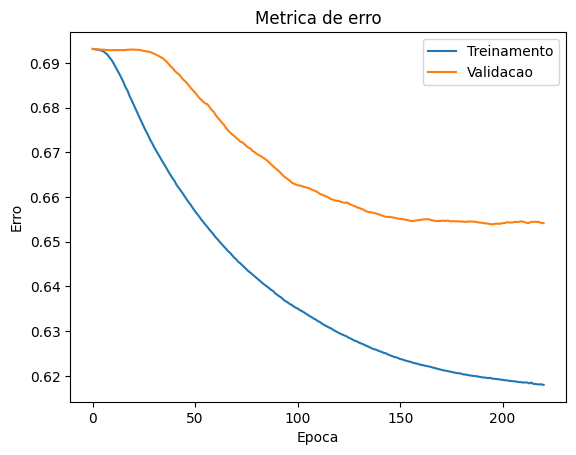

In [30]:
# Calculando a acuracia
_, accuracy_train = model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE, verbose=0)
_, accuracy_val = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE, verbose=0)

# Plotando os resultados
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])


print(f'--> Acuracia (treino): {accuracy_train:.4f}')
print(f'--> Acuracia (validacao): {accuracy_val:.4f}')
print(f"--> Ein - Eval = {accuracy_train - accuracy_val:.4f}") 
print(f"--> val_loss - train_loss = {(history.history['val_loss'][-1] - history.history['loss'][-1]):.4f}\n")

In [31]:
# Avaliando o modelo com o classification report
Y_pred_train = np.round(model.predict(X_train))
print('Classification Report (treino):')
print(classification_report(Y_train, Y_pred_train))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Classification Report (treino):
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       104
           1       0.61      0.65      0.63       104

    accuracy                           0.62       208
   macro avg       0.62      0.62      0.61       208
weighted avg       0.62      0.62      0.61       208



In [32]:
Y_pred_val = np.round(model.predict(X_val))
print('Classification Report (validacao):')
print(classification_report(Y_val, Y_pred_val))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Classification Report (validacao):
              precision    recall  f1-score   support

           0       0.59      0.65      0.62        26
           1       0.61      0.54      0.57        26

    accuracy                           0.60        52
   macro avg       0.60      0.60      0.59        52
weighted avg       0.60      0.60      0.59        52



# Obtendo as métricas do teste

In [ ]:
"""Y_pred_test = np.round(model.predict(X_test))
print('Classification Report (teste):')
print(classification_report(Y_test, Y_pred_test))
unique, counts = np.unique(Y_test, return_counts=True)
print("Quantidade de amostras de cada classe: ", dict(zip(unique, counts)))
unique, counts = np.unique(Y_pred_test, return_counts=True)
print("Quantidade de amostras previstas de cada classe: ", dict(zip(unique, counts)))"""

'Y_pred_test = np.round(model.predict(X_test))\nprint(\'Classification Report (teste):\')\nprint(classification_report(Y_test, Y_pred_test))\nunique, counts = np.unique(Y_test, return_counts=True)\nprint("Quantidade de amostras de cada classe: ", dict(zip(unique, counts)))\nunique, counts = np.unique(Y_pred_test, return_counts=True)\nprint("Quantidade de amostras previstas de cada classe: ", dict(zip(unique, counts)))'